Herkesi Merhabalar. bu yazımızda zaman serilerin de en çok kullanılan modellerden biri olan lstm model ile ileriye yönelik tahminler yapmaya çalışacağız. Şöyle bir fark ile ki lstm model ile bir gün değil ileriye yönelik 7 gün tahmini yapmaya çalışacağız. 
Data seti olarak yahoo finance ile çektiğimiz bir bankanın 2000 yılından itibaren bu zamana kadar olan verisini kullanacağız.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
import yfinance as yf
import mplfinance as mpf


import warnings
warnings.filterwarnings("ignore")

# Read the Dataset

In [2]:
import yfinance as yf
data_df = yf.download(tickers="AKBNK.IS", end="2022-07-25")
data_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-05-10,6.137479,6.410256,6.001091,6.137479,-138486.203125,1284067
2000-05-11,6.137479,6.273867,5.864702,6.137479,-138486.203125,608846
2000-05-12,6.273867,6.410256,6.001091,6.273867,-141563.656250,2283592
2000-05-15,6.137479,6.273867,6.001091,6.137479,-138486.203125,122956
2000-05-16,6.001091,6.137479,5.864702,6.001091,-135408.765625,1331524
...,...,...,...,...,...,...
2022-07-18,8.030000,8.290000,8.030000,8.270000,8.270000,87714847
2022-07-19,8.240000,8.540000,8.180000,8.500000,8.500000,106346801
2022-07-20,8.540000,8.570000,8.400000,8.560000,8.560000,109726652


yahoo finance apisi bize dünya üzerinde ki  bir çok ülke ki  hisse senetlerinin ve para birimlerinin verisini 1 satırlık kod ile çekmemizi sağlıyor.
download metodunun bazı paramaetreleri var. 
* tickers paramatresine hisse senedi adını yazıyoruz.
* start paramaetresi ile istediğimiz tarihten itibaren verileri getirebiliyoruz.
* end parametresi ise istedğimiz tarihe kadar olan verileri çekmemize yardımcı oluyor.

burada en eski tarihten itibaren olan verileri getirmesini istediğim için start paramatresine herhangi bir tarih vermiyorum

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5579 entries, 2000-05-10 to 2022-07-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5579 non-null   float64
 1   High       5579 non-null   float64
 2   Low        5579 non-null   float64
 3   Close      5579 non-null   float64
 4   Adj Close  5579 non-null   float64
 5   Volume     5579 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 305.1 KB


elimizde akbanka ait 6 sütün 5579 satırlık veri var. 
volume int diğerleri ise float veri tipinde.

In [4]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,5579.0,5.058235e+00,2.373236e+00,0.362677,3.344045e+00,5.693437e+00,6.808116e+00,9.603388e+00
High,5579.0,5.125646e+00,2.397054e+00,0.374376,3.426204e+00,5.760000e+00,6.885286e+00,9.650000e+00
Low,5579.0,4.986654e+00,2.346123e+00,0.327579,3.279736e+00,5.594845e+00,6.722372e+00,9.480000e+00
Close,5579.0,5.052858e+00,2.369930e+00,0.362677,3.344045e+00,5.691308e+00,6.808116e+00,9.540000e+00
Adj Close,5579.0,-3.649806e+03,1.063866e+04,-141563.656250,2.416744e+00,4.824937e+00,5.899675e+00,9.540000e+00
Volume,5579.0,2.597412e+07,3.863686e+07,0.000000,6.855098e+06,1.352965e+07,2.751291e+07,5.006192e+08


veri setimize daha detaylı göz atıyoruz. 

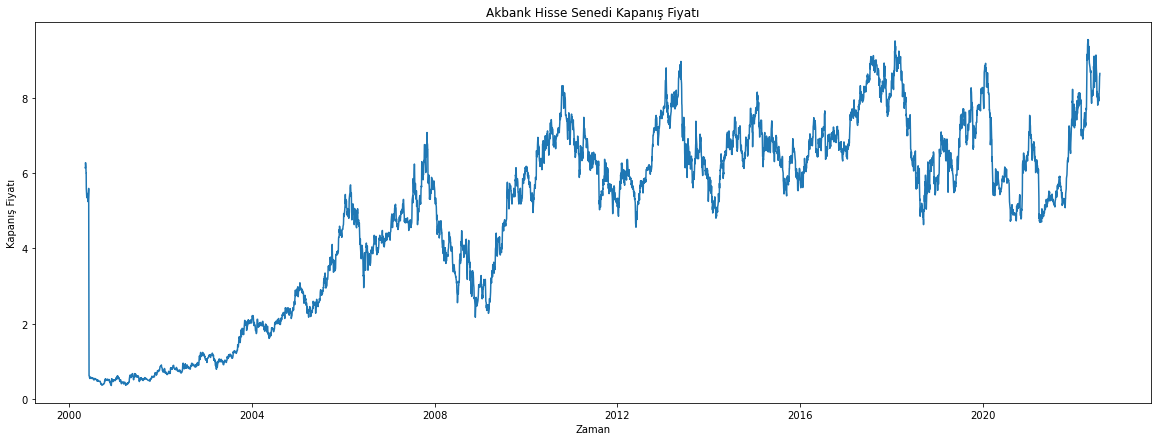

In [5]:
import matplotlib.pyplot  as plt
fig = plt.figure(figsize = (20, 7))
plt.plot(data_df["Close"])
plt.title("Akbank Hisse Senedi Kapanış Fiyatı")
plt.xlabel("Zaman")
plt.ylabel("Kapanış Fiyatı")
plt.show()

Görüldüğü gibi 2000 yılı içerisinde hisse senedi ani bir düşüşle 1 tl nin altına kadar düşüyor. Ancak 2006- 2007 yıllarından itibaren günümüze kadar benzer şekidel hareket ettiğini gözlemliyoruz. 

In [6]:
kolerasyon = data_df.corr()
kolerasyon

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999555,0.999519,0.999275,0.510340,0.276211
High,0.999555,1.000000,0.999371,0.999532,0.510102,0.282605
Low,0.999519,0.999371,1.000000,0.999586,0.510698,0.271763
Close,0.999275,0.999532,0.999586,1.000000,0.510273,0.277546
Adj Close,0.510340,0.510102,0.510698,0.510273,1.000000,0.141757
Volume,0.276211,0.282605,0.271763,0.277546,0.141757,1.000000


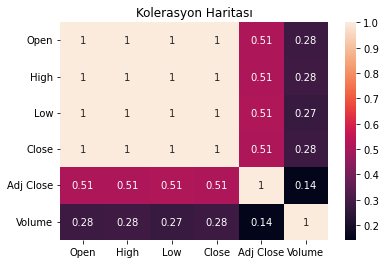

In [7]:
sns.heatmap(kolerasyon, annot = True)
plt.title("Kolerasyon Haritası")
plt.show()

Görüldüğü gibi close değişkenimiziz açılış, kapanış, düşük ve yüksek değerlerle arasında ki kolerasyon 1 yani yüksek pozitif yönlü bir ilişki var.

# Bağımlı ve Bağımsız Değişken Seçimi

In [8]:
close = data_df["Close"]
close.head()

Date
2000-05-10    6.137479
2000-05-11    6.137479
2000-05-12    6.273867
2000-05-15    6.137479
2000-05-16    6.001091
Name: Close, dtype: float64

In [9]:
close.shape

(5579,)

In [10]:
#close = close[:5500]

In [11]:
def to_x_y(frame, time_step, b):
    df_as_numpy = frame.values
    X = []
    y = []
    for i in range(len(df_as_numpy)- time_step):
        row = [[a for a in df_as_numpy[i:i+time_step]]]
        label = [a for a in df_as_numpy[i+time_step: i+time_step+b ]]
        X.append(row)
        y.append(label)
    return np.array(X), np.array(y)    

In [12]:
time_step = 15
b = 7
X, y = to_x_y(close, time_step, b)

yazdığımız bu fonksiyon yardımı ile bağımı ve bağımısz değişkenimizi oluşturacağız. Bu fonksiyonun 3 parametresi var. birincisi kapanış fiyatı değerlerimiz ikincisi ise time_step yani eğitim setinde geçmişe dönük kaç günlük veri istiyoruz. 3. ise ileriye dönük kaç günlük tahmin almak istiyoruz. Biz bu çalışmada geçmişe dönüş 15 günlük veri ile ileriye dönük 7 günlük tahmin yapacağız. 

In [13]:
X[-1]

array([[8.31000042, 8.02000046, 8.02000046, 8.15999985, 7.94999981,
        7.80000019, 7.90999985, 8.06000042, 8.09000015, 7.96000004,
        7.90999985, 8.27000046, 8.5       , 8.56000042, 8.57999992]])

In [15]:
y[-1]

[8.640000343322754]

In [16]:
len(y)

5564

In [17]:
a = np.zeros((5,3))
a

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [18]:
y1 = pd.DataFrame(np.zeros((close.shape[0]-time_step, 7)), columns = [0, 1, 2, 3, 4, 5, 6])

In [19]:
for i in range((len(y))):
    for j in range((len(y[i]))):
        y1[j][i] = y[i][j]

In [20]:
y1 = y1.values

In [21]:
X.shape, y1.shape

((5564, 1, 15), (5564, 7))

In [32]:
X = X[:5557]
y1 = y1[:5557]

In [34]:
y1.shape

(5557, 7)

### Train ve Test Split

In [38]:
X_train, y_train = X[:4500], y1[:4500]
X_val, y_val = X[4500:5000], y1[4500:5000]
X_test, y_test = X[5000:], y1[5000:]
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(4500, 1, 15) (4500, 7)
(500, 1, 15) (500, 7)
(557, 1, 15) (557, 7)


Verimizin ilk 4500 değerini train seti, sonraki 500 değeri validation seti ve en son ki 564 değeri ise test seti olarak ayırıyoruz

In [45]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.callbacks import ModelCheckpoint

In [45]:
model = Sequential()
model.add(LSTM(250, input_shape = (1,time_step), return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(b, activation=  "linear"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 250)               266000    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1757      
                                                                 
Total params: 267,757
Trainable params: 267,757
Non-trainable params: 0
_________________________________________________________________


model yapımızı oluşturduk.burda lstm yapısı içinde 250 tane nöron kullanmayı tercih ettim. dropoutumuz 0.3. output olarak tahmin etmek istediğimiz gün sayısı kadar nöron kullanıyoruz yani yukarıda tanımladığımız b değeri.

In [46]:
cp = ModelCheckpoint("model/" ,save_best_only = True)
model.compile(loss ='mean_squared_error', optimizer = "Adam")

In [47]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [cp], batch_size = 32)

Epoch 1/100
131/141 [==========================>...] - ETA: 0s - loss: 2.9543

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 4s 20ms/step - loss: 2.7760 - val_loss: 0.2749
Epoch 2/100
141/141 [==============================] - ETA: 0s - loss: 0.3044

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 3s 19ms/step - loss: 0.3044 - val_loss: 0.1934
Epoch 3/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2215 - val_loss: 0.2181
Epoch 4/100
124/141 [=========================>....] - ETA: 0s - loss: 0.2061

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 2s 17ms/step - loss: 0.2053 - val_loss: 0.1657
Epoch 5/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1830 - val_loss: 0.1769
Epoch 6/100
121/141 [========================>.....] - ETA: 0s - loss: 0.1669

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 3s 19ms/step - loss: 0.1684 - val_loss: 0.1436
Epoch 7/100
125/141 [=========================>....] - ETA: 0s - loss: 0.1575

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 2s 18ms/step - loss: 0.1580 - val_loss: 0.1391
Epoch 8/100
140/141 [============================>.] - ETA: 0s - loss: 0.1635

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 3s 18ms/step - loss: 0.1638 - val_loss: 0.1348
Epoch 9/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1478 - val_loss: 0.1848
Epoch 10/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1520 - val_loss: 0.1378
Epoch 11/100
140/141 [============================>.] - ETA: 0s - loss: 0.1446

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 2s 17ms/step - loss: 0.1449 - val_loss: 0.1343
Epoch 12/100
125/141 [=========================>....] - ETA: 0s - loss: 0.1477

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 3s 18ms/step - loss: 0.1483 - val_loss: 0.1330
Epoch 13/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1436 - val_loss: 0.1336
Epoch 14/100
138/141 [============================>.] - ETA: 0s - loss: 0.1351

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 2s 18ms/step - loss: 0.1342 - val_loss: 0.1259
Epoch 15/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1345 - val_loss: 0.1272
Epoch 16/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1427 - val_loss: 0.1284
Epoch 17/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1277 - val_loss: 0.1310
Epoch 18/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1339 - val_loss: 0.1473
Epoch 19/100
134/141 [===========================>..] - ETA: 0s - loss: 0.1335

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 2s 16ms/step - loss: 0.1337 - val_loss: 0.1242
Epoch 20/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1302 - val_loss: 0.1445
Epoch 21/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1316 - val_loss: 0.1448
Epoch 22/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1330 - val_loss: 0.1413
Epoch 23/100
131/141 [==========================>...] - ETA: 0s - loss: 0.1230

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 3s 18ms/step - loss: 0.1239 - val_loss: 0.1234
Epoch 24/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1199 - val_loss: 0.1752
Epoch 25/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1221 - val_loss: 0.1267
Epoch 26/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1247 - val_loss: 0.1344
Epoch 27/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1199 - val_loss: 0.1251
Epoch 28/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1211 - val_loss: 0.1759
Epoch 29/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1239 - val_loss: 0.1342
Epoch 30/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1180 - val_loss: 0.1339
Epoch 31/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1187 - val_loss: 0.1273
Epoch 32/100
130/141 [==========================>...] - ETA: 0s - loss: 0.1199

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 2s 17ms/step - loss: 0.1193 - val_loss: 0.1234
Epoch 33/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1155 - val_loss: 0.1431
Epoch 34/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1206 - val_loss: 0.1290
Epoch 35/100
127/141 [==========================>...] - ETA: 0s - loss: 0.1185

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 2s 17ms/step - loss: 0.1173 - val_loss: 0.1217
Epoch 36/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1278 - val_loss: 0.1316
Epoch 37/100
128/141 [==========================>...] - ETA: 0s - loss: 0.1182

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 3s 18ms/step - loss: 0.1174 - val_loss: 0.1206
Epoch 38/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1135 - val_loss: 0.1402
Epoch 39/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1130 - val_loss: 0.1681
Epoch 40/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1290 - val_loss: 0.1593
Epoch 41/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1202 - val_loss: 0.1214
Epoch 42/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1102 - val_loss: 0.1281
Epoch 43/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1081 - val_loss: 0.1220
Epoch 44/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1071 - val_loss: 0.2252
Epoch 45/100
131/141 [==========================>...] - ETA: 0s - loss: 0.1131

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 2s 17ms/step - loss: 0.1116 - val_loss: 0.1203
Epoch 46/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1247 - val_loss: 0.1448
Epoch 47/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1093 - val_loss: 0.1211
Epoch 48/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1153 - val_loss: 0.1448
Epoch 49/100
126/141 [=========================>....] - ETA: 0s - loss: 0.1124

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 2s 16ms/step - loss: 0.1164 - val_loss: 0.1202
Epoch 50/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1137 - val_loss: 0.1365
Epoch 51/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1094 - val_loss: 0.1262
Epoch 52/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1142 - val_loss: 0.1213
Epoch 53/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1057 - val_loss: 0.1261
Epoch 54/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1177 - val_loss: 0.2088
Epoch 55/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1073 - val_loss: 0.1772
Epoch 56/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1189 - val_loss: 0.1252
Epoch 57/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1107 - val_loss: 0.1347
Epoch 58/100
126/141 [=========================>....] - ETA: 0s - loss: 0.1026

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 3s 18ms/step - loss: 0.1036 - val_loss: 0.1187
Epoch 59/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1079 - val_loss: 0.1422
Epoch 60/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1126 - val_loss: 0.1683
Epoch 61/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1100 - val_loss: 0.1679
Epoch 62/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1094 - val_loss: 0.1197
Epoch 63/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1059 - val_loss: 0.1224
Epoch 64/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1077 - val_loss: 0.1736
Epoch 65/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1006 - val_loss: 0.1363
Epoch 66/100
129/141 [==========================>...] - ETA: 0s - loss: 0.1014

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 2s 17ms/step - loss: 0.1031 - val_loss: 0.1182
Epoch 67/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1131 - val_loss: 0.1253
Epoch 68/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1101 - val_loss: 0.1244
Epoch 69/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1133 - val_loss: 0.1259
Epoch 70/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1099 - val_loss: 0.1208
Epoch 71/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1126 - val_loss: 0.1717
Epoch 72/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1153 - val_loss: 0.1464
Epoch 73/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1074 - val_loss: 0.1238
Epoch 74/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1038 - val_loss: 0.1450
Epoch 75/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1067 - val_loss:

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 2s 17ms/step - loss: 0.1095 - val_loss: 0.1178
Epoch 79/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1078 - val_loss: 0.1204
Epoch 80/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1021 - val_loss: 0.1181
Epoch 81/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1085 - val_loss: 0.1187
Epoch 82/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1057 - val_loss: 0.1537
Epoch 83/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1031 - val_loss: 0.1455
Epoch 84/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1002 - val_loss: 0.1226
Epoch 85/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1004 - val_loss: 0.1202
Epoch 86/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1002 - val_loss: 0.1187
Epoch 87/100
127/141 [==========================>...] - ETA: 0s - loss: 0.1039

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


141/141 [==============================] - 3s 20ms/step - loss: 0.1027 - val_loss: 0.1174
Epoch 88/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1041 - val_loss: 0.1184
Epoch 89/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1067 - val_loss: 0.1185
Epoch 90/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1097 - val_loss: 0.1401
Epoch 91/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1027 - val_loss: 0.1207
Epoch 92/100
141/141 [==============================] - 0s 3ms/step - loss: 0.0992 - val_loss: 0.1205
Epoch 93/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1048 - val_loss: 0.1755
Epoch 94/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1051 - val_loss: 0.1327
Epoch 95/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1039 - val_loss: 0.1267
Epoch 96/100
141/141 [==============================] - 1s 3ms/step - loss: 0.0992 - val_loss:

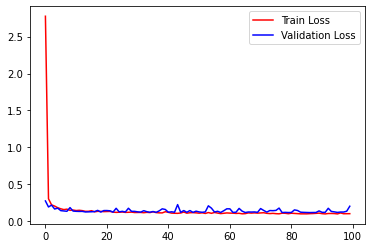

In [48]:
dictry = {"Train Loss":history.history["loss"], "Validation Loss": history.history["val_loss"]}
plt.plot(dictry["Train Loss"], label = "Train Loss", color = "red")
plt.plot(dictry["Validation Loss"], label = "Validation Loss", color = "blue")
plt.legend();

In [49]:
from tensorflow.keras.models import load_model
model = load_model("model/")

kaydedilen modeli load ediyoruz.

In [50]:
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

Öncelikle Test setimizin ilk 7 günlük ardından test data üzerinden tahmin ettiğimiz ilk 7 günlük değerleri inceliyoruz.

In [64]:
y_test[1]

array([5.78999996, 5.78999996, 5.67999983, 5.69000006, 5.73999977,
       6.03999996, 5.92000008])

In [65]:
y_test_pred[1]

array([5.6547904, 5.6783485, 5.681908 , 5.698029 , 5.692752 , 5.68041  ,
       5.7114553], dtype=float32)

In [ ]:
Görüldüğü gibi gerçek değerlerle tahmin ettiğimiz değerler birbirine oldukça yakın. 

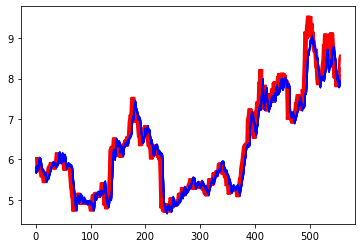

In [51]:
plt.plot(y_test, color = "red")
plt.plot(y_test_pred, color = "blue")
plt.show();

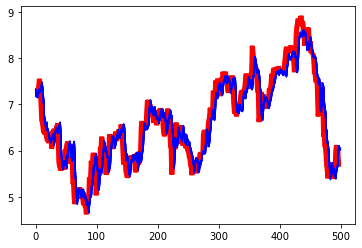

In [62]:
plt.plot(y_val, color = "red")
plt.plot(y_val_pred, color = "blue")
plt.show()

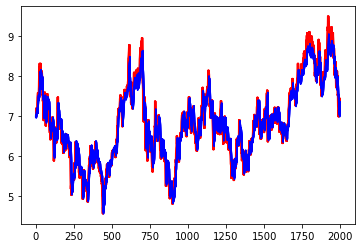

In [63]:
plt.plot(y_train[2500:], color = "red")
plt.plot(y_train_pred[2500:], color = "blue")
plt.show()

görüldğü gibi hem train hem validation hemde test setlerinde tahmin ve gerçek değerler birbirine çok yakın..

In [ ]:
y_test[:1]

In [54]:
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [55]:
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

In [56]:
r2_val = r2_score(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

In [59]:
scores = { 
    "Train Data" : {"R2 Score" : r2_train,
                      "Mean Absolute Error" : mae_train,
                      "Mean Squared Error" : mse_train,
                    "Root Mean Squared Error" : rmse_train},
        "Validation Data" : {"R2 Score" : r2_val,
                      "Mean Absolute Error" : mae_val,
                      "Mean Squared Error" : mse_val,
                    "Root Mean Squared Error" : rmse_val},
        "Test Data " : {"R2 Score" : r2_test,
                      "Mean Absolute Error" : mae_test,
                      "Mean Squared Error" : mse_test,
                    "Root Mean Squared Error" : rmse_test} 
        }
Scores = pd.DataFrame(scores)
Scores.T

,R2 Score,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
Train Data,0.991394,0.159115,0.052109,0.228273
Validation Data,0.866956,0.252589,0.117440,0.342695
Test Data,0.927637,0.219324,0.108362,0.329184


R2 scorlarımız ve Hata metriclerimiz tabloda. Modelimizde gayet iyi çalışıyor. Şu unutulmamalıdır ki modelimizin ileri doğru tahmin gün sayısı arttıkça  tarin ve validation setlerinde hatalarımız artacaktır.